In [1]:
# Generalized PSF Finder

In [2]:
from scipy.optimize import curve_fit
import random

from astropy.io import fits
import numpy as np
import scipy.interpolate
from scipy.interpolate import splev, splrep

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import pandas as pd

In [3]:
import ipywidgets as widgets

import pickle

In [4]:
with open('./shifted_values.pkl', 'rb') as f:
     loaded_data = pickle.load(f)

loaded_data

{'wavelength': 0     [4431.46137068054, 4431.476152444564, 4431.490...
 1     [4464.045010302595, 4464.059900753942, 4464.07...
 2     [4497.119781202617, 4497.134781979524, 4497.14...
 3     [4530.68121275581, 4530.696325481602, 4530.711...
 4     [4564.750958699148, 4564.76618506938, 4564.781...
                             ...                        
 66    [9061.78623925518, 9061.816466120454, 9061.846...
 67    [9486.57628353487, 9486.607927347213, 9486.639...
 68    [9637.169683115359, 9637.201829253212, 9637.23...
 69    [9792.632159733768, 9792.664824438625, 9792.69...
 70    [9953.17398115629, 9953.207181371019, 9953.240...
 Name: shifted wavelengths, Length: 71, dtype: object,
 'flux': 0     [0.8949158314042824, 0.7815706774264399, 0.828...
 1     [0.9304602218385664, 0.9055602214297426, 0.804...
 2     [0.9681062116715451, 0.9410797799020679, 1.068...
 3     [0.442616295897608, 0.43149351085405907, 0.322...
 4     [0.7329985280363767, 0.816532642581396, 0.6904...
           

In [5]:
#step 1: find the minima 
def minima_scanner_with_thresholds(x,y, thresholds):
    ''' sets minima flux value to be considered for a minima (threshold). must be less than 1'''
    min_x = []
    min_y = []
    for i in np.arange(1, len(x)-1):
        if y[i] > thresholds[0] and y[i] < thresholds[1]: 
            if y[i-1] > y[i] and y[i] < y[i+1]:
                min_x.append(x[i])
                min_y.append(y[i]) 
    return min_x, min_y   

In [6]:
#step 2: find maxima 
def simple_maxima(x, y, limit):
    ''' this requires min values and assumes a threshold has been applied'''
    l = limit #minimum value to be considered as a maxima 
    max_x = []
    max_y = []
    for i in np.arange(1, len(x)-1):
        if y[i] > l and y[i]:
            if y[i-1] < y[i] and y[i] > y[i+1]:
                max_x.append(x[i])
                max_y.append(y[i])
    return max_x, max_y


In [7]:
#step 3: see where minima fit in maxima array to create fitting domains
def find_range(x,y, intial_guess = False):
    ''' Given the parameters of a spectra, it will find the ranges of possible gaussian candidates. 
    the aim is for it to also give inital parameters estimations for curve fitting'''
    ranges = []
    outs = []
    minx, miny = minima_scanner_with_thresholds(x,y, [0.4,0.8])
    maxx, maxy = simple_maxima(x, y, 0.9)
    insertions = np.searchsorted(maxx, minx) #gives at which indeces to put the mininima in the maxima array to be sorted still. 
    
    tempxr = []
    tempyr = []
    tempxl = []
    tempyl = []
    
    
    for i in insertions: 
        tempxr.append(maxx[i])
        tempyr.append(maxy[i])
        tempxl.append(maxx[i-1])
        tempyl.append(maxy[i-1])

    for j in np.arange(len(tempxl)): 
        temprange = []
        tempout = []
        for i in np.arange(len(x)):
            if x[i] > tempxl[j] and x[i] < tempxr[j]:
                temprange.append(x[i])
                tempout.append(y[i])
        ranges.append(temprange)
        outs.append(tempout)
        
    #finds inital guesses:
    if intial_guess: 
        
        amps = []
        means = []
        stds = []
        for i in np.arange(len(ranges)):
            amps.append(min(outs[i]))
            means.append(ranges[i][np.argmin(outs[i])])
            stds.append(np.std(outs[i]))
        
        
        return ranges, outs, amps, means, stds
                
   #just returns ranges for graphing purposes 
    else:
        return ranges, outs

In [8]:
#step 4: fit to a guassian:
def gaussian(x,a, b, c):
    '''a is amplitude, b is  the mean (where i think it is), c is standard deviation (sqrt(variance))''' 
    #offset = x[0] #good estimate
    return -a*np.e**(-(x-b)**2/(2*c**2)) + 1 # + offset 

In [9]:
#step 5: return PSF value:
def return_psf(index = 0): #index goes to the length of the amps, means, and stds arrays 
    bfit, cov = curve_fit(gaussian,domains[index], ranges[index], p0 = [amps[index],means[index],stds[index]], absolute_sigma=True)
    #test_gaussian = gaussian(domains[index], bfit[0],bfit[1],bfit[2])
    return bfit[2] #this is the spread 

In [10]:
def psf_per_order(x,y):
    minx, miny = minima_scanner_with_thresholds(x,y, [0.2,0.8])
    maxx, maxy = simple_maxima(x, y, 0.9)
    domains, ranges, amps, means, stds = find_range(x,y, intial_guess = True)
    #gaussian(x,a, b, c)
    psfs = []
    def return_psf(index = 0): #index goes to the length of the amps, means, and stds arrays 
        bfit, cov = curve_fit(gaussian,domains[index], ranges[index], p0 = [amps[index],means[index],stds[index]], absolute_sigma=True)
        #test_gaussian = gaussian(domains[index], bfit[0],bfit[1],bfit[2])
        return bfit[2] #this is the spread 
    
    for i in np.arange(len(amps)):
        try:
            psf = return_psf(i)
            if psf > 0 and psf < 2:
                psfs.append(psf)
        except:
            pass
    return psfs

Dictionaries override themselves without me wanting them to, so this copy_data dictionary will be used for injections and the loaded_data dictionary will be used for comparison purposes 

In [11]:

copy_data = loaded_data.copy()
wls_comp = loaded_data['wavelength']
fls_comp = loaded_data['flux']
order = np.arange(len(wls_comp))

wls = copy_data['wavelength']
fls = copy_data['flux']

In [12]:
# some of these orders are kinda broken, would need to go back:
tot_psfs = []

for o in range(1,3):
    tot_psfs += psf_per_order(wls[o],fls[o])
for o in range(5,7):
    tot_psfs += psf_per_order(wls[o],fls[o])  
for o in range(8,18):
    tot_psfs += psf_per_order(wls[o],fls[o])
for o in range(21,26):
    tot_psfs += psf_per_order(wls[o],fls[o])
for o in range(27,31):
    tot_psfs += psf_per_order(wls[o],fls[o])
for o in range(35,46):
    tot_psfs += psf_per_order(wls[o],fls[o])
# for o in range(50):
#     tot_psfs += psf_per_order(wls[o],fls[o])

#psfs

C:\Users\alica\AppData\Local\Temp\ipykernel_20172\1209340471.py:5: RuntimeWarning: invalid value encountered in true_divide
  return -a*np.e**(-(x-b)**2/(2*c**2)) + 1 # + offset
C:\Users\alica\anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [13]:
len(tot_psfs)

1748

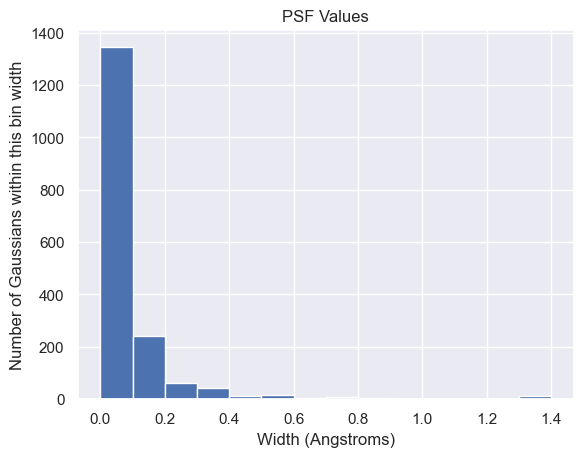

In [14]:
plt.hist(np.abs(tot_psfs),bins= np.linspace(0.0,1.4,15))
plt.title('PSF Values')
plt.xlabel('Width (Angstroms)')
plt.ylabel('Number of Gaussians within this bin width')
plt.show()

In [15]:
print('max PSF: ', max(tot_psfs), '\nMin PSF: ',min(tot_psfs), '\nMean PSF: ', np.mean(tot_psfs), '\nMedian PSF: ', np.median(tot_psfs)
     )

max PSF:  1.3062242723834834 
Min PSF:  0.000698597258019712 
Mean PSF:  0.10428926147428784 
Median PSF:  0.05624063939166195


In [16]:
#adding in random emission features:

def emission_gaussian(x,a, b, c):
    '''a is amplitude, b is  the mean (where i think it is), c is standard deviation (sqrt(variance))''' 
    #offset = x[0] #good estimate
    return a*np.e**(-(x-b)**2/(2*c**2)) #starts at translation 0


In [17]:
def periodic_gaussian(sigma,l,x,xprime,p):
    exponent = []
    function = []
    for i in x:
        exponent = np.append(exponent,-2/l**2 * (np.sin(np.pi*(((i-xprime)/p))))**2)
    function = np.append(function,sigma**2 * np.e**exponent)
    return function + 1

In [18]:
periodic_gaussian(1,1,np.arange(-5,5),1,1)

array([2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [19]:
test_x = np.linspace(-10,10,1000)
test_gaussian2 = periodic_gaussian(1,1,test_x,1,10)
test_gaussian3 = periodic_gaussian(1,1,test_x,5.5,10)

In [20]:
# plt.figure(figsize=(10,6))
# plt.plot(test_x,test_gaussian2, label = 'no horizontal offset')
# plt.plot(test_x,test_gaussian3, label = 'horizontal offset = 1/2')
# plt.title('Test of periodic gaussian', fontsize = 18)
# plt.xlabel('unit of separation')
# plt.ylabel('amplitude')
# plt.legend(loc = 'upper right')
# plt.show()

In [21]:
fit_maybe = emission_gaussian(wls[0],0.1,np.mean(wls[0]), np.mean(tot_psfs))

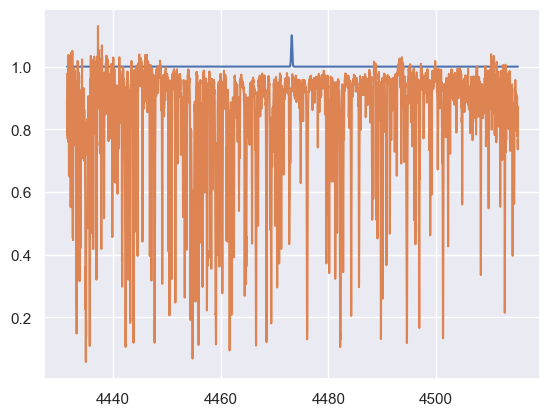

In [22]:
plt.plot(wls[0], fit_maybe + 1)
plt.plot(wls[0],fls[0])

## Injection


the plan is to inject 20 randomly generated gaussians that have width of the median PSF and a height that ranges from 0.1 above the continuum to 1 above the contiuum (plotted from 1.1 to 2). Through this injection process, we will then recover the PSF and heights of the fits and see what differences arise. We will begin with a threshold that only contains our injected gaussians and then lower the threshold to contain values that are naturally occuring in the spectra. 

In [23]:
#collect heights and widths of onese recovered and ones that werent - injected background, recovered foreground -- 

#make histogram of recovered and injected characteristics (width and height) overlapped 

In [24]:
#add my favorite plots into my drafted report 

In [25]:
#first we need to set a threshold, which for testing purposes will be set to half of the range i gave, so anything greater than 1.5 

threshold = 1.5 



In [26]:
#now lets pick the order(s) that i like the most -- which are the ones closest to 1

import ipywidgets as widgets

In [27]:
def plot_order(order = 0):
    plt.figure(figsize = (14,4))
    plt.plot(wls[order],fls[order])
    plt.title('order: ' + str(order))
    plt.ylabel('normalized flux')
    plt.xlabel('wavelength (A)')
    plt.axhline(1, c = 'orange', linestyle = '--')

In [28]:
widgets.interact(plot_order, order = widgets.Play(value=0,
    min=0,
    max = len(wls)-1,
    step=1,
    interval=1000,
    ))

interactive(children=(Play(value=0, description='order', interval=1000, max=70), Output()), _dom_classes=('wid…

<function __main__.plot_order(order=0)>

In [29]:
injection_orders = [0, 3, 7, 11, 24, 31, 52] # 7 arrays should be enough to get a general idea for what we are looking for

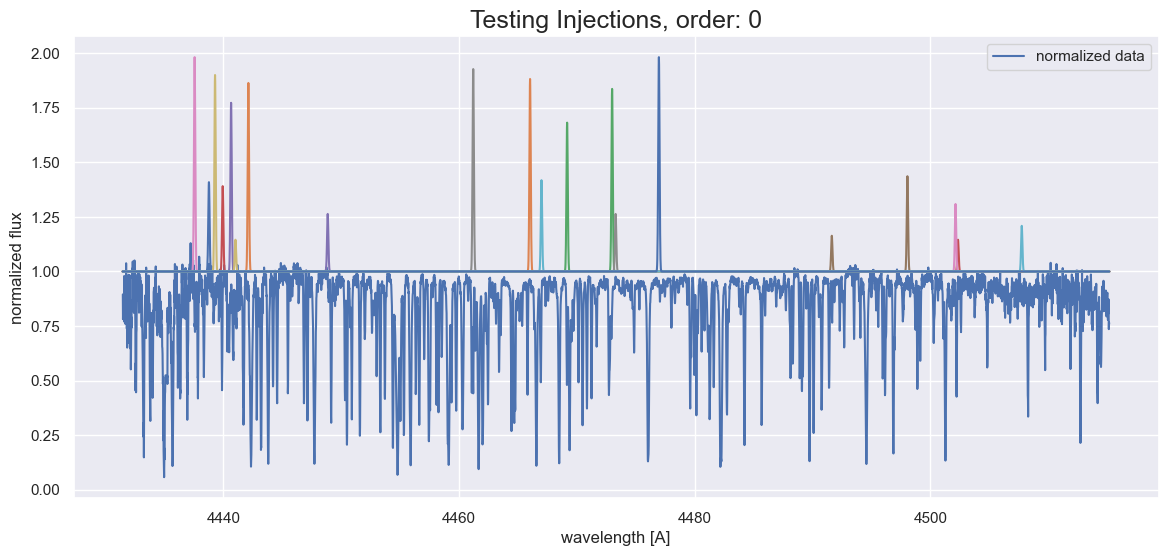

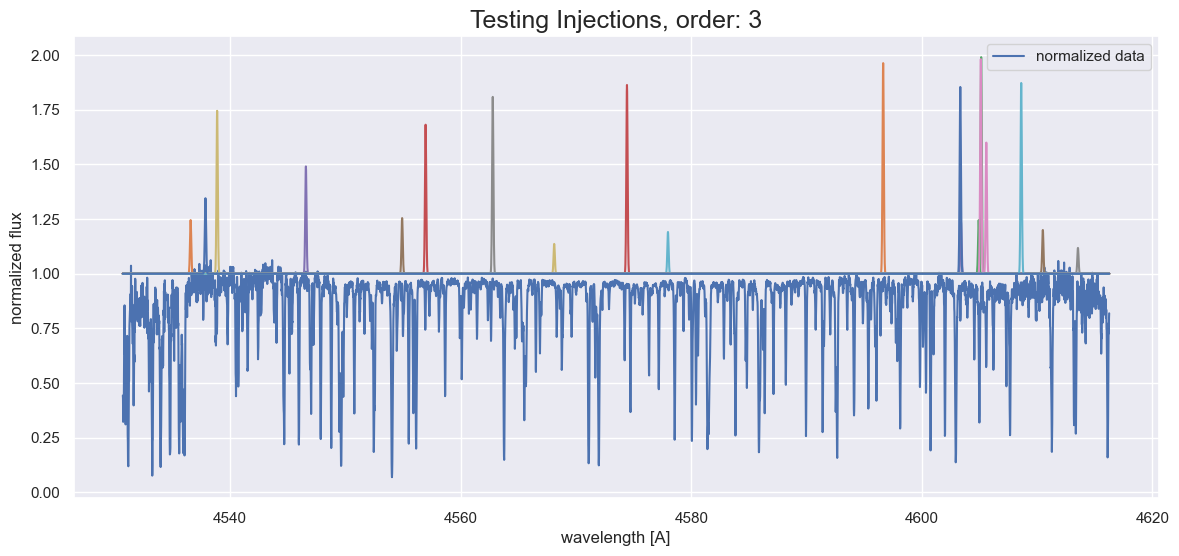

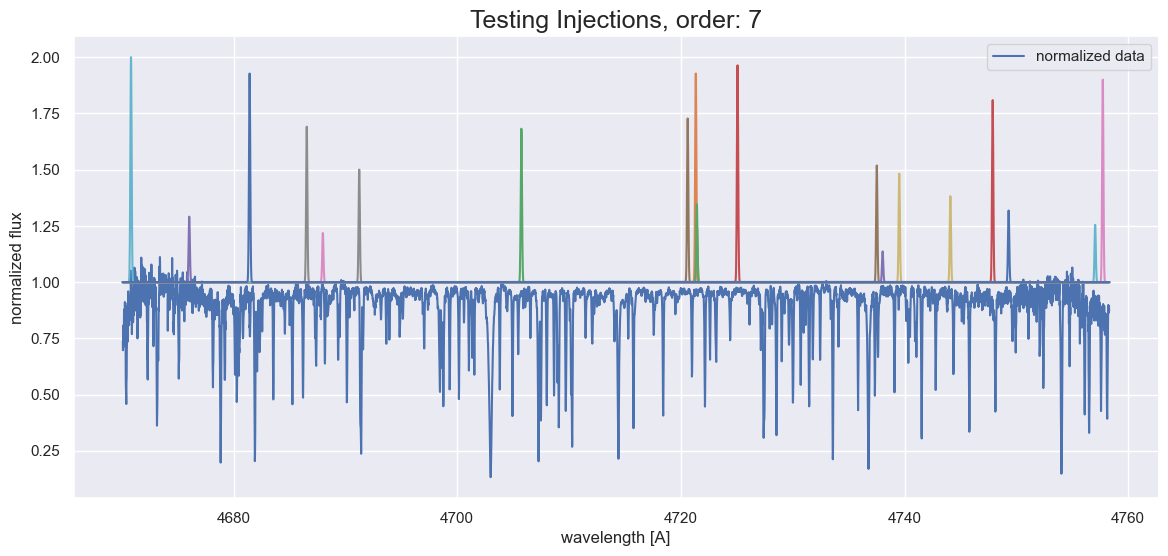

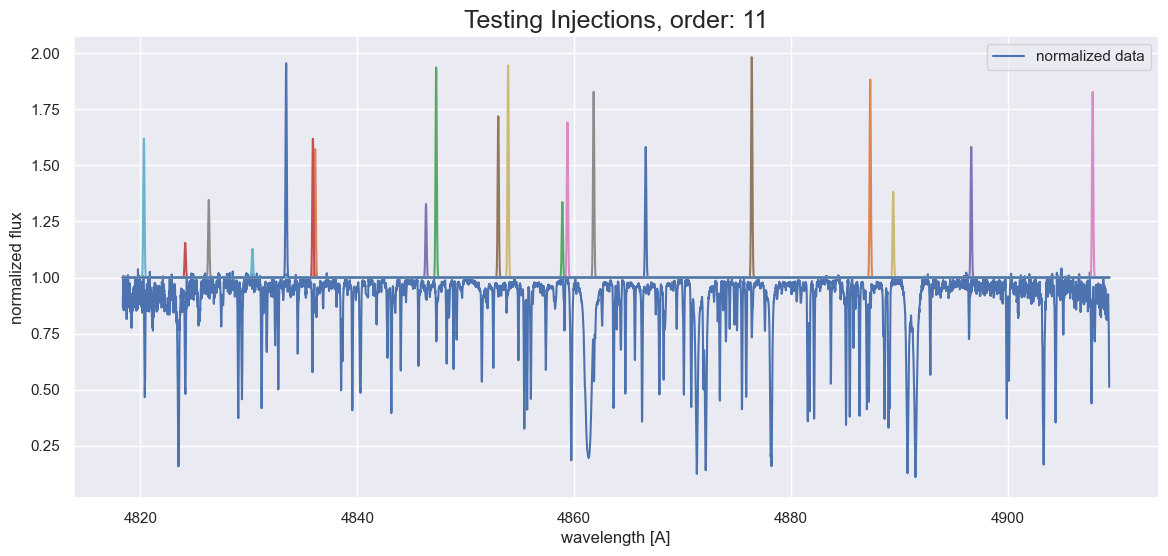

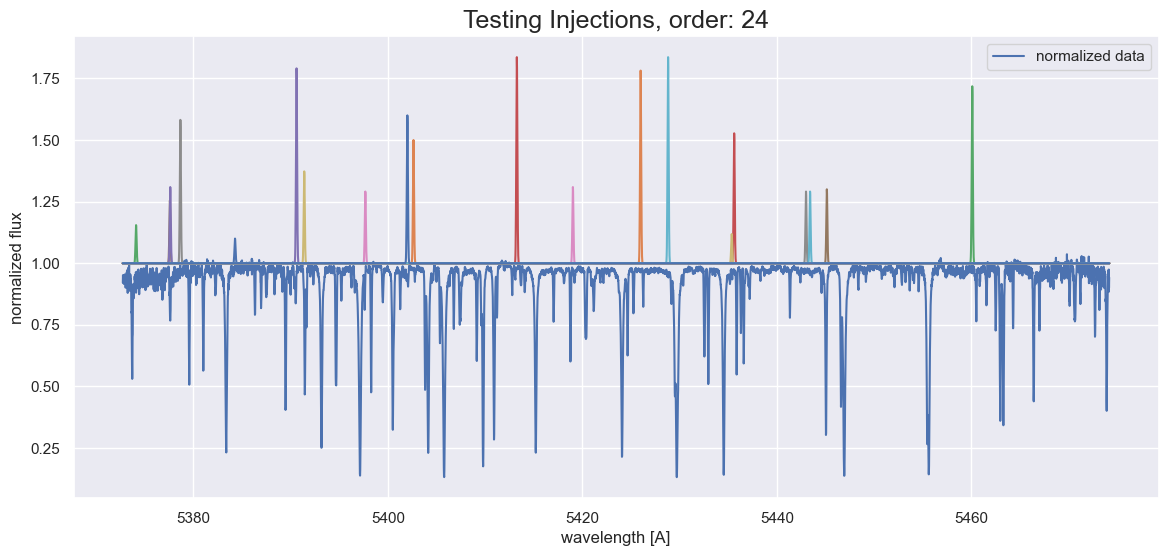

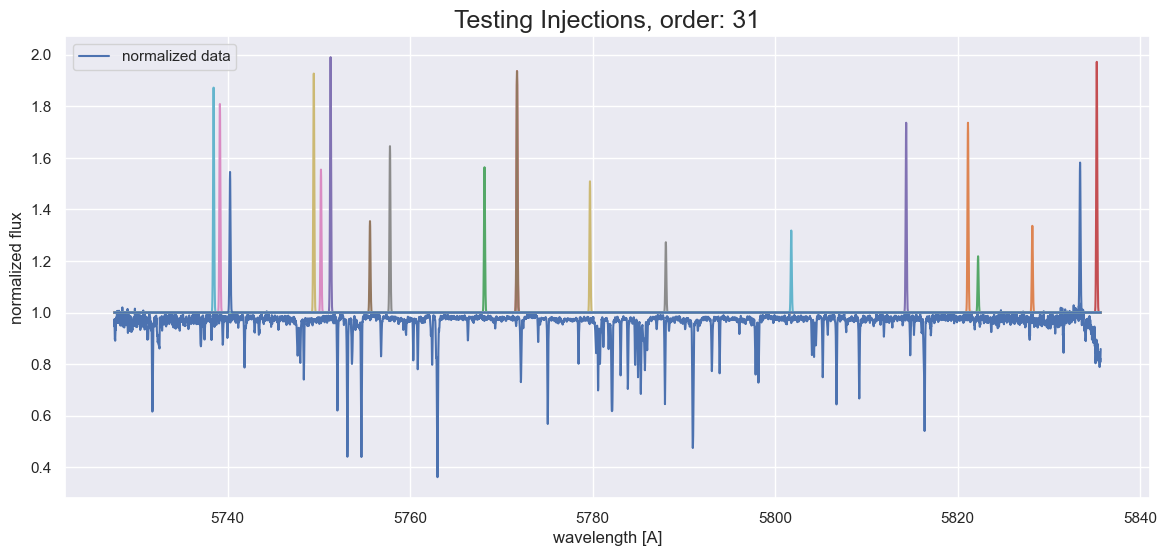

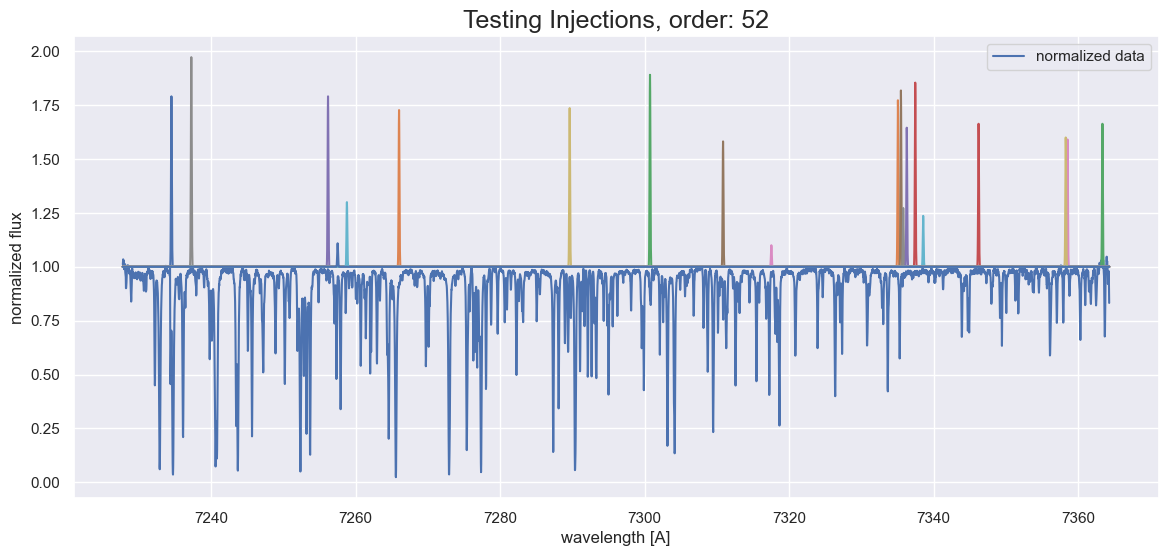

In [30]:
for a in injection_orders: #normalized spectrum 
    plt.figure(figsize = (14,6))
    plt.plot(wls[a],fls[a], label = 'normalized data')
    for i in np.arange(20): #Plots gaussian emissions per normalized spectrum 
        fit = emission_gaussian(wls[a],np.random.choice(np.linspace(0.1,1,100)),
                                               np.random.choice(wls[a]), np.median(tot_psfs)
                                              ) 
        plt.plot(wls[a], fit + 1)
        plt.ylabel('normalized flux')
        plt.xlabel('wavelength [A]')
        plt.title('Testing Injections, order: ' + str(a), fontsize = 18)
        plt.legend()

In [31]:
emission_gaussian(wls[a],
                        np.random.choice(np.linspace(0.1,1,100)),
                        np.random.choice(wls[a]), 
                        np.median(tot_psfs))

array([0., 0., 0., ..., 0., 0., 0.])

add our laser injections into the normalized spectrum -- which makes much more sense, the injections will be added to the array at those correspoding wavelength values

make a table for the injected positions and "intensity" (amplitude) and then a second table with the same column labels but for the recovered values
- it will be different than expected just based off of where it falls and if its in an absorption line or on the continuum

- make two histograms based off of these tables and plot them over eachother, then the similariaties and differences will be more apparent


questions:
>does this mean that our injections will require the same number of pixels / wavelength values (no adding in our own that fall into the gap between wavelength values)?

> im going to assume as much and just make the range be the like 5 neighboring pixels on either side

In [32]:
#revised injection methods 
injection_orders


#lets just focus on order 0 for the test case;

[0, 3, 7, 11, 24, 31, 52]

In [33]:
#so the indeces are the wl and fl values for that order. the only thing that will be changin is the flux values when we add the inejctions
inj_0 = wls[0], fls[0]

In [34]:
inj_0

(array([4431.46137068, 4431.47615244, 4431.49093426, ..., 4515.13755863,
        4515.15261951, 4515.16768044]),
 array([0.89491583, 0.78157068, 0.82844585, ..., 0.73591921, 0.76729065,
        0.75944083]))

Text(0.5, 0, 'wavelength (ang)')

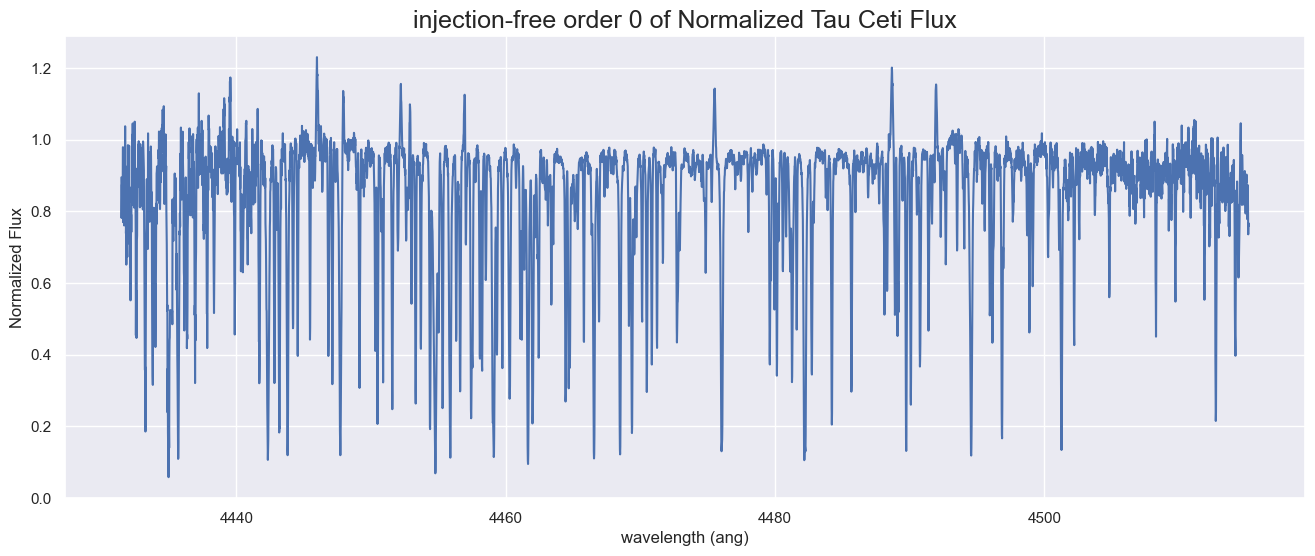

In [59]:
#plotting to see differences:

plt.figure(figsize = (16,6))
plt.plot(wls[0],fls[0])
plt.title('injection-free order 0 of Normalized Tau Ceti Flux', fontsize = 18)
plt.ylabel('Normalized Flux')
plt.xlabel('wavelength (ang)')


In [60]:
#test one injection:
# for a in injection_orders: #normalized spectrum 
#     plt.figure(figsize = (14,6))
#     plt.plot(wls[a],fls[a], label = 'normalized data')
#     for i in np.arange(20): #Plots gaussian emissions per normalized spectrum 
#         fit = emission_gaussian(wls[a],np.random.choice(np.linspace(0.1,1,100)),
#                                                np.random.choice(wls[a]), np.median(tot_psfs)
#                                               )
#         plt.plot(wls[a], fit)
#         plt.ylabel('normalized flux')
#         plt.xlabel('wavelength [A]')
#         plt.title('Testing Injections, order: ' + str(a), fontsize = 18)
#         plt.legend()

In [61]:
for a in np.arange(10): #np.random.choice(np.linspace(0.1,1,100))
    wl = wls[0]
    fl = fls[0]
    position = np.random.choice(len(wl))
    domain = wl[position - 9: position + 10]
    fit = emission_gaussian(domain, 0.3,
                            wl[position], np.median(tot_psfs)
                                              )
    test = fit + fl[position-9 : position+10]

5099

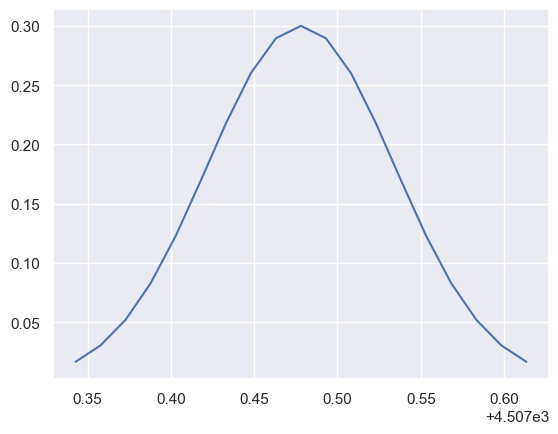

In [62]:
plt.plot(domain, fit)
domain
position

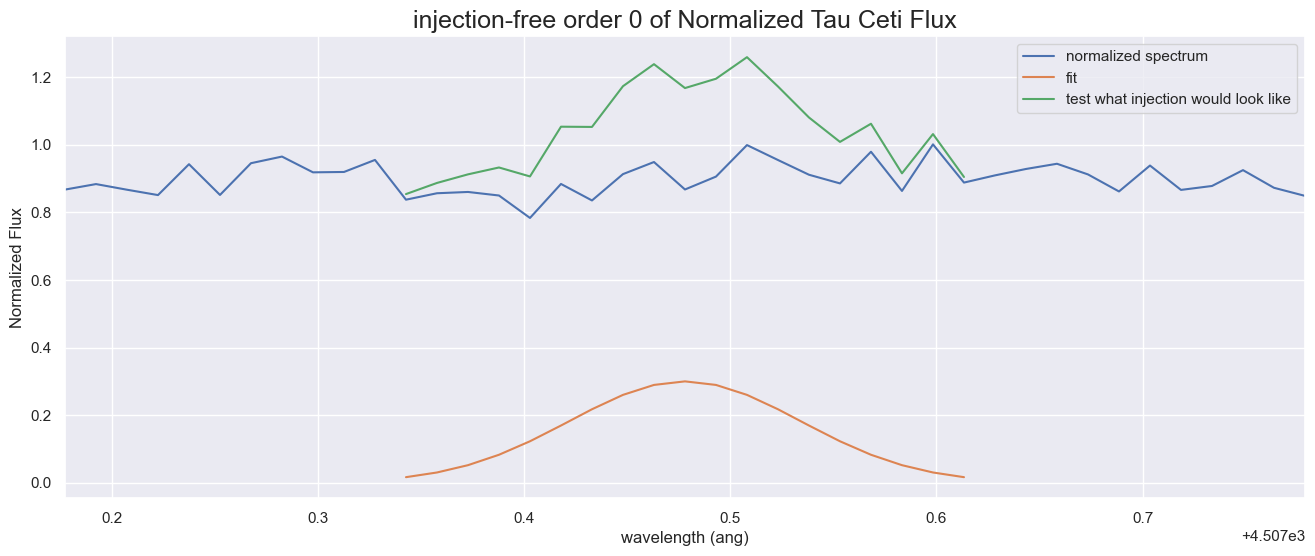

In [63]:
plt.figure(figsize = (16,6))
plt.plot(wls[0],fls[0], label = 'normalized spectrum')
plt.plot(domain, fit, label = 'fit')
plt.plot(domain, test, label = 'test what injection would look like')
plt.title('injection-free order 0 of Normalized Tau Ceti Flux', fontsize = 18)
plt.ylabel('Normalized Flux')
plt.xlabel('wavelength (ang)')
plt.xlim(wl[position - 20],wl[position + 20]) 
plt.legend()
plt.show()

As we can see zoomed in, the test fit happens to land in a local minima, which causes the laser  emission to be perceived at a lower intensity

This will probably happen a lot, but to test it lets do some more fits and see if we can randomly generate some good looking fits

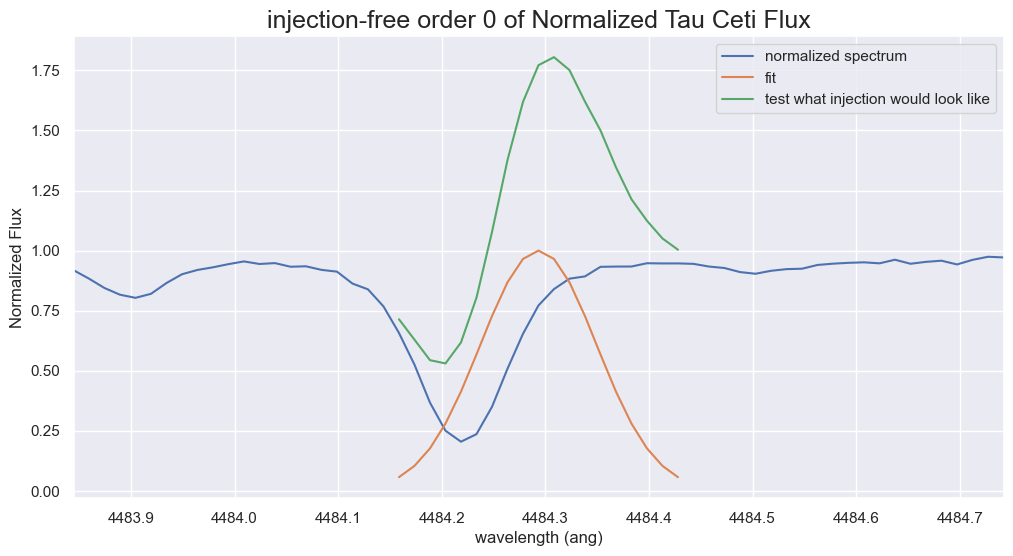

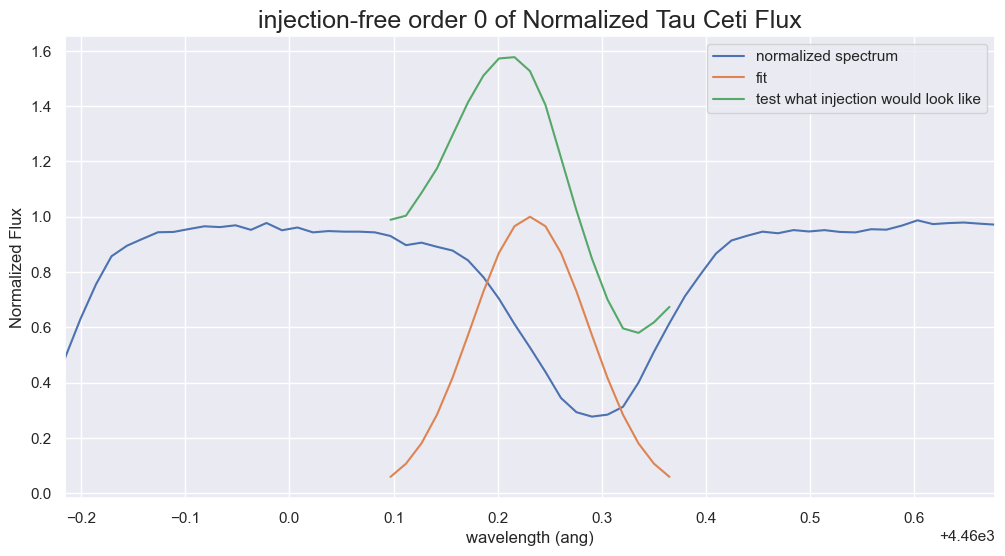

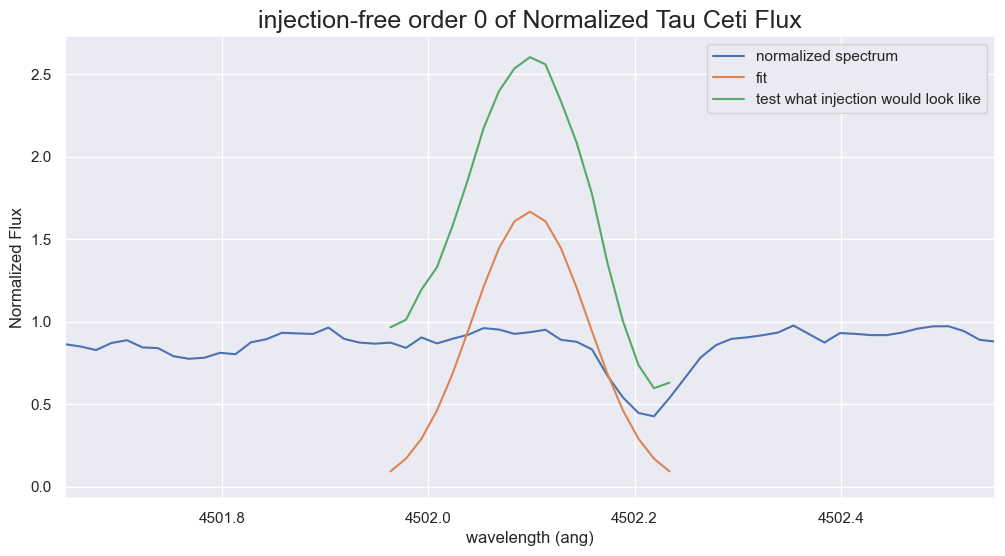

In [64]:

for a in np.arange(3): #np.random.choice(np.linspace(0.1,1,100))
    wl = wls[0]
    fl = fls[0]
    position = np.random.choice(len(wl))
    domain = wl[position - 9: position + 10]
    fit = emission_gaussian(domain, np.random.choice(np.linspace(0.5,2,10)),
                            wl[position], np.median(tot_psfs)
                                              )
    test = fit + fl[position-9 : position+10]
    #now plotting it:
    plt.figure(figsize = (12,6))
    plt.plot(wls[0],fls[0], label = 'normalized spectrum')
    plt.plot(domain, fit, label = 'fit')
    plt.plot(domain, test, label = 'test what injection would look like')
    plt.title('injection-free order 0 of Normalized Tau Ceti Flux', fontsize = 18)
    plt.ylabel('Normalized Flux')
    plt.xlabel('wavelength (ang)')
    plt.xlim(wl[position - 30],wl[position + 30]) 
    plt.legend()
    plt.show()

Now that we know the randomized injections are working, its time to store some data and run some test!

In [65]:
#functions in this section:

#making randomly generated positions:
def intensity_array(n, lower, higher):
    ''' Returns an array of n randomly generated intensities within the given bounds'''
    interval = np.linspace(lower, higher, 100)
    i = np.random.choice(interval, n)
    return i

#makes randomly generated positons:
def position_array(n, order):
    '''Returns an array of n randomly generated positions for the given order
    where the position is the index in the array, not the wavelength'''
    return np.random.choice(np.arange(len(wls[order])),n)

#now time to add these bad bois to order 0 and try and collect some data: 
def create_range(position, order):
    '''returns an array of values that have position centered'''
    return wls[order][position - 9:position + 10]
    
#now lets see if we can apply this to the whole table: 
def ranges_array(tbl, order):
    ranges = []
    for i in np.arange(tbl.num_rows):
        temp = create_range(tbl.column(0).item(i), order)
        ranges.append(temp)
    return ranges
                     
    


In [66]:
len(wls[0])

5611

In [67]:
#time to store it all in a table, with 10 injections to begin: 
from datascience import *

In [68]:
test_injections = Table().with_columns('Position',position_array(20,0),
                                       'Intensity', intensity_array(20,0.2,2))

In [69]:
test_injections

Position,Intensity
1564,0.345455
5465,1.83636
2948,1.58182
3903,1.92727
2745,1.52727
2308,1.6
4623,1.49091
3211,0.509091
234,0.6
4295,0.781818


In [70]:
create_range(test_injections.column(0).item(0),0)

array([ 4454.50669077,  4454.52154941,  4454.53640809,  4454.55126682,
        4454.56612561,  4454.58098444,  4454.59584332,  4454.61070226,
        4454.62556124,  4454.64042027,  4454.65527935,  4454.67013848,
        4454.68499766,  4454.69985689,  4454.71471617,  4454.7295755 ,
        4454.74443488,  4454.75929431,  4454.77415378])

In [71]:
test_with_ranges = test_injections.with_column('Range',ranges_array(test_injections, 0))

In [72]:
test_with_ranges

Position,Intensity,Range
1564,0.345455,[4454.5066907710525 4454.52154940599 4454.53640809049 44 ...
5465,1.83636,[4512.848889277981 4512.863942521544 4512.87899581532 45 ...
2948,1.58182,[4475.1185481403945 4475.133475529088 4475.148402967578 ...
3903,1.92727,[4489.396910581626 4489.4118855978095 4489.426860663944 ...
2745,1.52727,[4472.089319002221 4472.104236286493 4472.119153620528 4 ...
2308,1.6,[4465.575225508619 4465.590121064214 4465.605016669496 4 ...
4623,1.49091,[4500.191861950979 4500.206872975244 4500.221884049585 4 ...
3211,0.509091,[4479.046167362672 4479.061107852493 4479.0760483921495 ...
234,0.6,[4434.788510422026 4434.803303284193 4434.818096195704 4 ...
4295,0.781818,[4495.270946652448 4495.2859412623075 4495.300935922182 ...


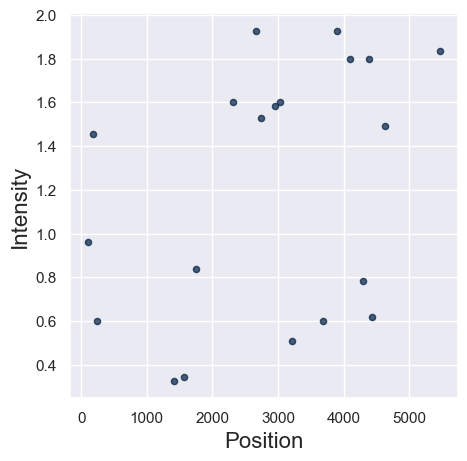

In [73]:
%matplotlib inline
test_with_ranges.scatter('Position','Intensity')
#this is kinda just checking that the data is spread out 

In [74]:
test_fits = []
for i in np.arange(test_injections.num_rows):
    r = test_with_ranges.column('Range')[i]
    a = test_with_ranges.column('Intensity').item(i)
    b = wls[0][test_with_ranges.column('Position').item(i)]
    c = np.median(tot_psfs)
    test_fits.append(emission_gaussian(r, a, b, c))

In [75]:
#now time to add it to the table" 

test_with_fits = test_with_ranges.with_column('Fit', test_fits)

In [76]:
test_with_fits

Position,Intensity,Range,Fit
1564,0.345455,[4454.5066907710525 4454.52154940599 4454.53640809049 44 ...,[0.020447758007466336 0.03700985491439437 0.062470630398 ...
5465,1.83636,[4512.848889277981 4512.863942521544 4512.87899581532 45 ...,[0.10088868544032176 0.18548465162123653 0.3174395757617 ...
2948,1.58182,[4475.1185481403945 4475.133475529088 4475.148402967578 ...,[0.09120592152953011 0.16599111080895246 0.2815478842185 ...
3903,1.92727,[4489.396910581626 4489.4118855978095 4489.426860663944 ...,[0.10911635447344312 0.1993488813383912 0.33927187450479 ...
2745,1.52727,[4472.089319002221 4472.104236286493 4472.119153620528 4 ...,[0.0884015850934231 0.16075699993177087 0.27247507417542 ...
2308,1.6,[4465.575225508619 4465.590121064214 4465.605016669496 4 ...,[0.09338256481633474 0.1695194744007502 0.28688601983244 ...
4623,1.49091,[4500.191861950979 4500.206872975244 4500.221884049585 4 ...,[0.08325176241356337 0.15253782786524667 0.2602696514782 ...
3211,0.509091,[4479.046167362672 4479.061107852493 4479.0760483921495 ...,[0.029206922051483647 0.05321135002022475 0.090338875101 ...
234,0.6,[4434.788510422026 4434.803303284193 4434.818096195704 4 ...,[0.03641257364216093 0.06556120207425534 0.1101531783019 ...
4295,0.781818,[4495.270946652448 4495.2859412623075 4495.300935922182 ...,[0.04393260478113523 0.08038893007374678 0.1370045588786 ...


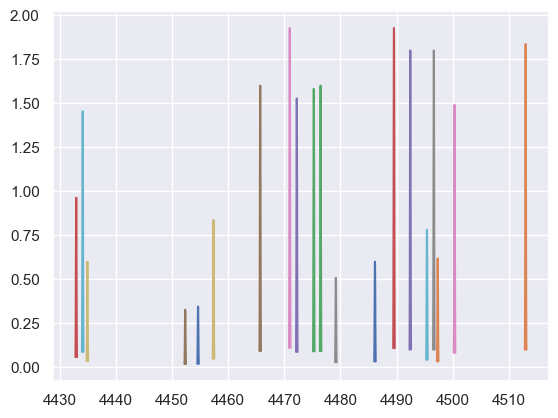

In [77]:
#plt.plot(wls[0],fls[0])
for i in np.arange(test_with_fits.num_rows):
    plt.plot(test_with_fits.column('Range')[i], test_with_fits.column('Fit')[i],)

In [78]:
#adding our fitted values to the original spectrum: 

def combine_injections(tbl, order):
    wl = wls[order]
    fl = fls[order]
    positions = tbl.column('Position')
    intensities = tbl.column('Intensity')
    fits = tbl.column('Fit')
    for f in np.arange(tbl.num_rows):
        fl[positions[f] - 9: positions[f] + 10] = fl[positions[f] - 9: positions[f] + 10] + fits[order]
    return fl
    
    
            

In [79]:
q = combine_injections(test_with_fits,0)

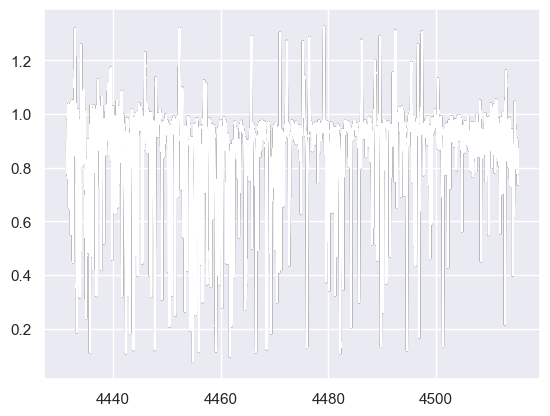

In [80]:
plt.plot(wls_comp[0],fls_comp[0],c = 'black')
plt.plot(wls[0],q, c = 'white')




In [ ]:
plt.figure(figsize = (12,5))
plt.plot(wls[0],fls[0])
#plt.xlim(4450,4480)
plt.title('Injections Added into Normalized Spectrum')
plt.ylabel('Normalized Flux')
plt.xlabel('Wavelength (A)')
plt.ylim(0,1.5)

plt.show()